This notebook presents the solutions for the first homework, given at the course _Data Mining_ 2018-2019, at the _University of Bucharest_. 

Due date: November 21, 2018.

# 1. Introduction

In this notebook we will explore the "_Dog Breeds Dataset_".

The notebook is divide in $4$ main sections:
  - Introduction
  - Data Analysis
  - Classification
  - Regression

# 2. Data Analysis

First we load the given dataset into a _pandas_ Data Frame.

In [0]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
np.random.seed(0)

data_set = pd.read_csv("dataset.csv")
data_set.head(3)

,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
0,Boxer,25182.8824,56.2856,8.4255,high,high,short,female,Cunningham
1,Akita,46910.4933,65.2520,12.1206,med,med,med,female,Carolyn
2,Golden Retriever,29460.9988,NaN,12.0012,med,med,long,female,Hill


The first thing we do, before any data analysis, is to take apart an evaluation set from the provided one which we will use just in the end, to validate our workflow.

Doing so, we will be sure that we are fair during our analysis process.

In [0]:
from sklearn.model_selection import train_test_split

reasoning_data, evaluation_data = train_test_split(data_set, test_size=0.15)

We will add a new feature to the data set in order to make plots more suggestive.

Thus, we will associate to each breed a color in order to be more easily distinguished. 

In [0]:
reasoning_data["Breed Name"].unique()

array(['Boxer', 'Golden Retriever', 'Akita', 'Bearded Collie'],
      dtype=object)

In [0]:
colors_dict = {"Boxer":"black", "Akita":"orange", "Golden Retriever":"green", 'Bearded Collie':"blue"}

In [0]:
reasoning_data = reasoning_data.assign(Color = lambda row: np.vectorize(lambda y: colors_dict[y])(row["Breed Name"]))
reasoning_data.head()

,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name,Color
271,Boxer,29397.2169,NaN,8.9308,high,med,short,female,Bennett,black
30,Golden Retriever,31067.6696,57.1414,11.1424,med,high,long,male,Farrell,green
403,Akita,42776.4186,65.3270,10.2722,low,low,med,male,Baker,orange
757,Boxer,32567.3858,56.4741,8.6217,high,high,short,female,Lopez,black
975,Akita,51639.7598,NaN,10.8557,low,med,med,female,Harper,orange


In [0]:
#Which features are not important:
#Color, Owner Name and maybe Sex
reasoning_data.groupby(['Breed Name', "Sex"]).count()["Color"]

reasoning_data.groupby(["Sex"]).mean()["Height(cm)"]
reasoning_data.groupby(["Breed Name"]).count()["Sex"]

Breed Name
Akita               209
Bearded Collie      212
Boxer               212
Golden Retriever    217
Name: Sex, dtype: int64

We can observe that our data set is well balanced, having almost the same number of data points in each class 

How many data points do we have?

In [0]:
reasoning_data.shape

(850, 10)

We can observe (from the shown data above) that there are columns which contain NaN (not a number /  not available). 

We will see which columns have missing values and think how can we fix this problem: 

In [0]:
reasoning_data.isnull().sum()

Breed Name           0
Weight(g)            0
Height(cm)         173
Longevity(yrs)       0
Energy level         0
Attention Needs      0
Coat Lenght          0
Sex                  0
Owner Name           0
Color                0
dtype: int64

We observe that the _Height(cm)_ is the only feature with missing values. Approximately $20\%$ $(173$ out of $850)$ of the data points have missing height.


The first idea would be to fill the missing values with the others mean.

Other approaches would be:
   - to ignore the data points which have missing height ;
   - see if the height is correlated with another feature and decide afterwards;
   - we will plot the weight and height in a scatter plot to see how the data is distributed.

Now we will investigate the correlations between features:

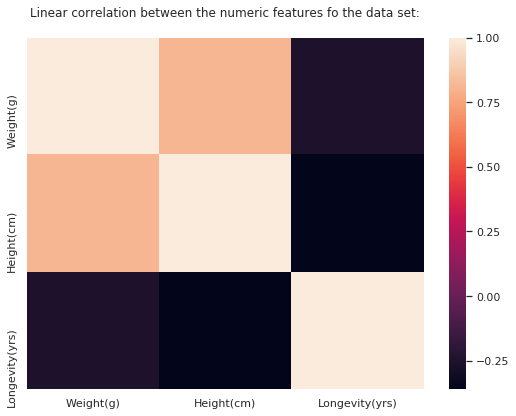

In [0]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8.9,6.47)})

plt.title("Linear correlation between the numeric features fo the data set:\n")
sns.heatmap(reasoning_data.corr())
plt.show()

We can see that Height(cm) is highly (linearly) correlated with the Weight(g).

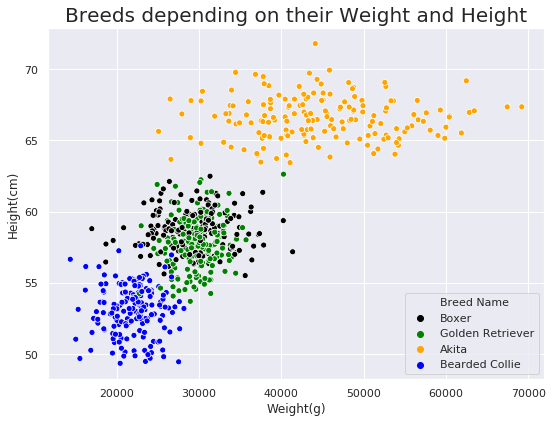

In [0]:
sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="Breed Name", palette=colors_dict\
                , data=reasoning_data[["Height(cm)", "Weight(g)", "Color", "Breed Name"]]\
               ).set_title("Breeds depending on their Weight and Height", fontdict={"fontsize":20})

plt.show()

We can see that the Height(cm) is a good predictor for the Akita breed. As well, the Bearded Collie is emphasized by Weight and Height.

Nevertheless, we notice that completing the missing values of for the Height with a simple mean or by doing a linear regression based only on the Weight may not be enough.

### Fill in the missing Height(cm) values

First we will investigate if the mean Height changes depending on each category:

In [0]:
reasoning_data.groupby(["Energy level"]).mean()["Height(cm)"]

Energy level
high    56.476144
low     63.247434
med     61.335364
Name: Height(cm), dtype: float64

In [0]:
reasoning_data.groupby(["Sex"]).mean()["Height(cm)"]

Sex
female    59.133362
male      58.894668
Name: Height(cm), dtype: float64

In [0]:
reasoning_data.groupby(["Attention Needs"]).mean()["Height(cm)"]

Attention Needs
high    56.767950
low     66.454490
med     64.000549
Name: Height(cm), dtype: float64

In [0]:
reasoning_data.groupby(["Coat Lenght"]).mean()["Height(cm)"]

Coat Lenght
long     54.584274
med      61.322248
short    59.356901
Name: Height(cm), dtype: float64

There seems to be small differences between these means and thus we will use all these categorical features to predict the Height.

Below we will plot the Height distribution with respect to the other features. 

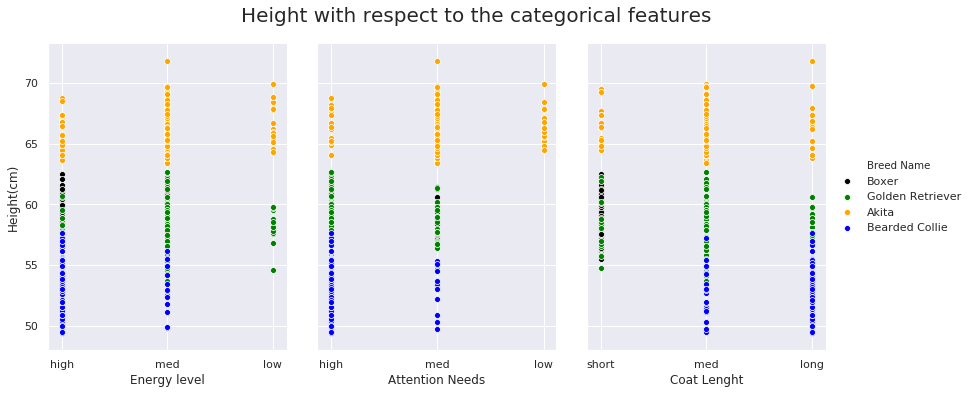

In [0]:
pair_plot = sns.pairplot(reasoning_data\
             , x_vars=["Energy level", "Attention Needs", "Coat Lenght"]
             , y_vars="Height(cm)", hue="Breed Name"\
             , palette=colors_dict, height=5.2\
             , aspect=.76)

pair_plot.fig.suptitle("Height with respect to the categorical features", fontsize=20, y=1.05)
plt.show()

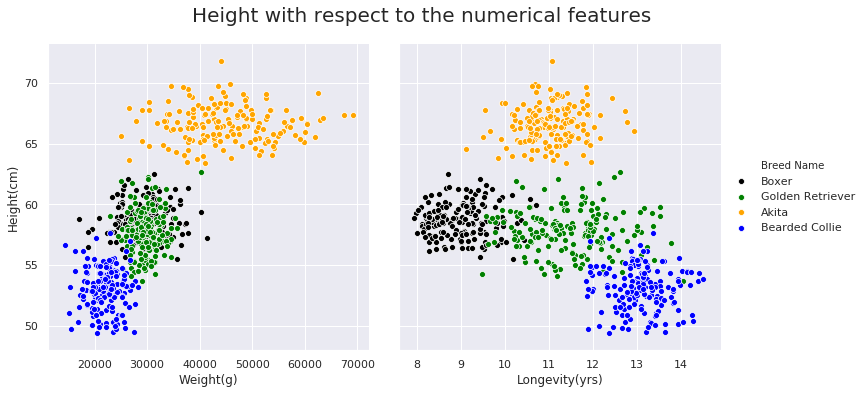

In [0]:
pair_plot = sns.pairplot(reasoning_data\
             , x_vars=["Weight(g)", "Longevity(yrs)"]\
             , y_vars="Height(cm)", hue="Breed Name", palette=colors_dict, height=5.2)

pair_plot.fig.suptitle("Height with respect to the numerical features", fontsize=20, y=1.05)
plt.show()

We now investigate how different methods of auto Height completion would work:

#### Fill in the missing Height with simple mean

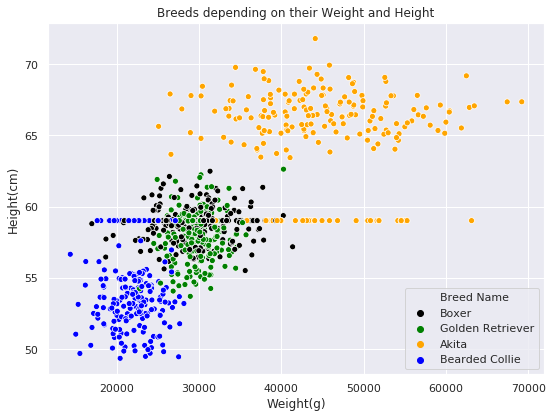

In [0]:
consistent_data = reasoning_data.copy()
consistent_data = consistent_data.fillna(reasoning_data["Height(cm)"].mean())

sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="Breed Name", palette=colors_dict\
                , data=consistent_data[["Height(cm)", "Weight(g)", "Color", "Breed Name"]]\
               ).set_title("Breeds depending on their Weight and Height")
plt.show()

Simple mean seams to not fit the generation model very well. Therefore, using this auto-completion method may have a bad impact on the results of our final prediction model.   

#### Fill in the missing Height by doing regression on the weight

We will investigate how well is the Height explained by the Weight by doing a simple Linear Regression to determine it.

The Linear Regression model having as predictor the Weight and as target the height has an R^2 score of 0.6611.


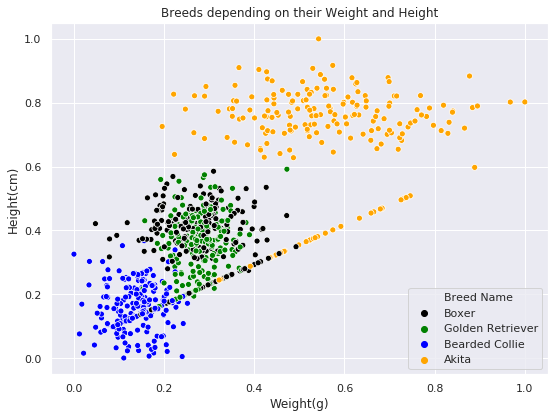

In [0]:
#Select only the desired columns and normalize data:
normalized_data               = reasoning_data.copy()
normalized_data["Height(cm)"] = (normalized_data["Height(cm)"]-normalized_data["Height(cm)"]\
                                 .min())/(normalized_data["Height(cm)"].max()\
                                          -normalized_data["Height(cm)"].min())
normalized_data["Weight(g)"]  = (normalized_data["Weight(g)"]-normalized_data["Weight(g)"]\
                                .min())/(normalized_data["Weight(g)"].max()\
                                         -normalized_data["Weight(g)"].min())
predict_height_data = normalized_data[["Height(cm)", "Weight(g)", "Breed Name"]].copy()

#Split the data points that have known Height from the others:
labeled_height_data   = predict_height_data.copy().dropna()
unlabeled_height_data = predict_height_data.copy().loc[reasoning_data.isnull().values.sum(axis=1)==1]

#Split labeled data into train and test:
from sklearn.model_selection import train_test_split
X, y = labeled_height_data["Height(cm)"], labeled_height_data["Weight(g)"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Train the Linear Regression model:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train.values.reshape((-1,1)), y_train.values.reshape((-1,1)))
print("The Linear Regression model having as predictor the Weight and as target the height has an R^2 score of {0:.4f}.".\
      format(lr_model.score(X_test.values.reshape((-1,1)), y_test.values.reshape((-1,1)))))

#Fill unlabeled data:
unlabeled_height_data["Height(cm)"] = lr_model.predict(unlabeled_height_data["Weight(g)"].values.reshape((-1,1))).reshape((-1))
new_HW_data = pd.concat([unlabeled_height_data.copy(), labeled_height_data.copy()])
new_HW_data = new_HW_data.sort_index()

sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="Breed Name", palette=colors_dict\
                , data=new_HW_data[["Height(cm)", "Weight(g)", "Breed Name"]]\
               ).set_title("Breeds depending on their Weight and Height")
plt.show()

Simple Linear Regression does not seem to capture the complexity of the generating model as well.

#### Fill in missing Height values using Random Forest on all the other features

We will investigate more complex regression models (such as Random Forest for regression, using as predictors the Weight, the Energy level, the Attention Needs, the Coat Length and the Sex) to predict the Height.

We get rid of following features:
  - Owner Name because it has to many categories and most of the Owners have only one dog, therefore this column does not provide much information.
  - Color is our artificial feature corespondent to each breed
  - The Longevity will be used as a target in the next exercise so we can not use it as a predictor

For the other categorical features we one hot encode them in order to be able to use them in our model. 

In [0]:
#We keep the feature Breed Name as it is (not as a dummy) in order to use it for plots in the end.
height_relevant_data = pd.get_dummies(reasoning_data.copy().drop(columns=["Owner Name", "Color", "Longevity(yrs)"]),\
                                     columns=["Energy level", "Attention Needs", "Coat Lenght", "Sex"])

labeled_height_data   = height_relevant_data.copy().dropna()
unlabeled_height_data = height_relevant_data.copy().loc[height_relevant_data.isnull().values.sum(axis=1)==1]

height_relevant_data.head()

,Breed Name,Weight(g),Height(cm),Energy level_high,Energy level_low,Energy level_med,Attention Needs_high,Attention Needs_low,Attention Needs_med,Coat Lenght_long,Coat Lenght_med,Coat Lenght_short,Sex_female,Sex_male
271,Boxer,29397.2169,NaN,1,0,0,0,0,1,0,0,1,1,0
30,Golden Retriever,31067.6696,57.1414,0,0,1,1,0,0,1,0,0,0,1
403,Akita,42776.4186,65.3270,0,1,0,0,1,0,0,1,0,0,1
757,Boxer,32567.3858,56.4741,1,0,0,1,0,0,0,0,1,1,0
975,Akita,51639.7598,NaN,0,1,0,0,0,1,0,1,0,1,0


We split the data and normalize it: 

#### Normalization

In [0]:
#Split labeled data into train and test:
from sklearn.model_selection import train_test_split
X, y = labeled_height_data.drop(columns=["Height(cm)"]), labeled_height_data["Height(cm)"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

norm_X_train_mean = X_train.drop(columns=["Breed Name"]).mean()
norm_X_train_std  = X_train.drop(columns=["Breed Name"]).std()

normed_X_train = (X_train.drop(columns=["Breed Name"]) - norm_X_train_mean) / norm_X_train_std
normed_X_test  = (X_test.drop(columns=["Breed Name"]) - norm_X_train_mean) / norm_X_train_std
normed_unlabeled  = (unlabeled_height_data.drop(columns=["Breed Name", "Height(cm)"]) - norm_X_train_mean) / norm_X_train_std
normed_labeled  = (labeled_height_data.drop(columns=["Breed Name", "Height(cm)"]) - norm_X_train_mean) / norm_X_train_std

normed_X_train["Breed Name"] = X_train["Breed Name"]
normed_X_test["Breed Name"]  = X_test["Breed Name"]
normed_unlabeled["Breed Name"]   = unlabeled_height_data["Breed Name"]
normed_labeled[["Breed Name", "Height(cm)"]]     = labeled_height_data[["Breed Name", "Height(cm)"]]
X_train = normed_X_train
X_test  = normed_X_test
unlabeled_height_data = normed_unlabeled
labeled_height_data = normed_labeled

Now we can train our regression models

The RF Regression model having as predictor the Weight and as target the height has an R^2 score of 0.7841.


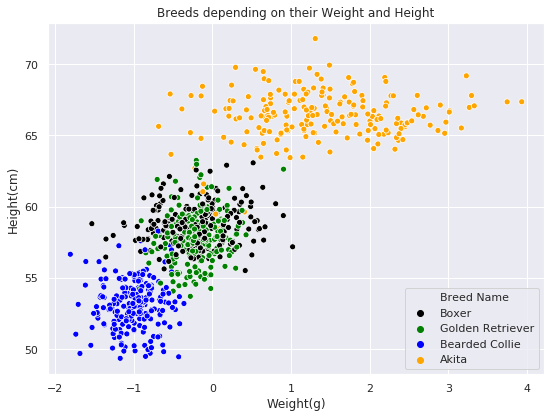

The K Neighbors Regression model having has an R^2 score of 0.6281.


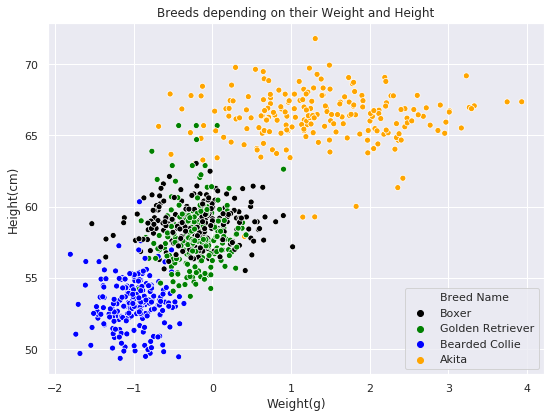

/home/stefan/anaconda3/envs/data_mining/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The MLP Regression model has an R^2 score of 0.6552.


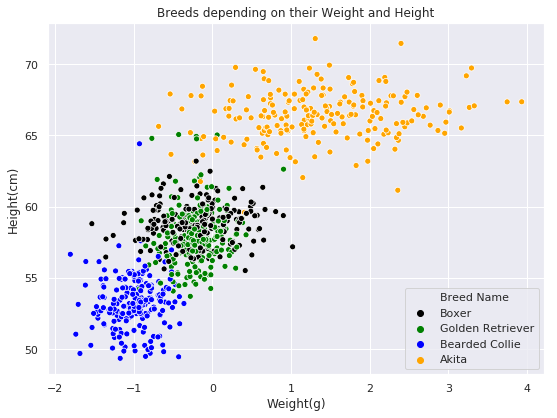

In [0]:
#Train the Linear Regression model:

#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
rfr_model  = RandomForestRegressor(n_estimators=50)
rfr_model.fit(X_train.drop(columns=["Breed Name"]).values, y_train.values.ravel())
print("The RF Regression model having as predictor the Weight and as target the height has an R^2 score of {0:.4f}.".\
      format(rfr_model.score(X_test.drop(columns=["Breed Name"]).values, y_test.values.ravel())))

#Fill unlabeled data:
# unlabeled_height_data.drop(columns=["Height(cm)"], inplace=True) 
unlabeled_height_data["Height(cm)"] = rfr_model.predict(unlabeled_height_data\
                                                        .drop(columns=["Breed Name"])\
                                                        .values).reshape((-1))
new_HW_data = pd.concat([unlabeled_height_data.copy(), labeled_height_data.copy()])
new_HW_data = new_HW_data.sort_index()

sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="Breed Name", palette=colors_dict\
                , data=new_HW_data[["Height(cm)", "Weight(g)", "Breed Name"]]\
               ).set_title("Breeds depending on their Weight and Height")
plt.show()

#K Neighbors Regressor
from sklearn.neighbors import KNeighborsRegressor
knr_model  = KNeighborsRegressor(n_neighbors=13, )
knr_model.fit(X_train.drop(columns=["Breed Name"]).values, y_train.values.ravel())
print("The K Neighbors Regression model having has an R^2 score of {0:.4f}.".\
      format(knr_model.score(X_test.drop(columns=["Breed Name"]).values, y_test.values.reshape((-1,1)))))

#Fill unlabeled data:
unlabeled_height_data.drop(columns=["Height(cm)"], inplace=True) 
unlabeled_height_data["Height(cm)"] = knr_model.predict(unlabeled_height_data\
                                                        .drop(columns=["Breed Name"])\
                                                        .values).reshape((-1))
new_HW_data = pd.concat([unlabeled_height_data.copy(), labeled_height_data.copy()])
new_HW_data = new_HW_data.sort_index()

sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="Breed Name", palette=colors_dict\
                , data=new_HW_data[["Height(cm)", "Weight(g)", "Breed Name"]]\
               ).set_title("Breeds depending on their Weight and Height")
plt.show()


#K Neighbors Regressor
from sklearn.neural_network import MLPRegressor
mlpr_model = MLPRegressor(hidden_layer_sizes=(128, 64, 16, 16, 8), activation="relu", max_iter=450, )
mlpr_model.fit(X_train.drop(columns=["Breed Name"]).values, y_train.values.ravel())
print("The MLP Regression model has an R^2 score of {0:.4f}.".\
      format(mlpr_model.score(X_test.drop(columns=["Breed Name"]).values, y_test.values.reshape((-1,1)))))

#Fill unlabeled data:
unlabeled_height_data.drop(columns=["Height(cm)"], inplace=True)
unlabeled_height_data["Height(cm)"] = mlpr_model.predict(unlabeled_height_data\
                                                        .drop(columns=["Breed Name"])\
                                                        .values).reshape((-1))
new_HW_data = pd.concat([unlabeled_height_data.copy(), labeled_height_data.copy()])
new_HW_data = new_HW_data.sort_index()

sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="Breed Name", palette=colors_dict\
                , data=new_HW_data[["Height(cm)", "Weight(g)", "Breed Name"]]\
               ).set_title("Breeds depending on their Weight and Height")
plt.show()

# #SVM Regression
# from sklearn.svm import SVR
# svr_model = SVR(gamma="scale")
# svr_model.fit(X_train.drop(columns=["Breed Name"]).values, y_train.values.ravel())
# print("The Support Vector Regression model has an R^2 score of {0:.4f}.".\
#       format(rfr_model.score(X_test.drop(columns=["Breed Name"]).values, y_test.values.reshape((-1,1)))))

# #Fill unlabeled data:
# unlabeled_height_data.drop(columns=["Height(cm)"], inplace=True)
# unlabeled_height_data["Height(cm)"] = svr_model.predict(unlabeled_height_data\
#                                                         .drop(columns=["Breed Name"])\
#                                                         .values).reshape((-1))
# new_HW_data = pd.concat([unlabeled_height_data.copy(), labeled_height_data.copy()])
# new_HW_data = new_HW_data.sort_index()

# sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="Breed Name", palette=colors_dict\
#                 , data=new_HW_data[["Height(cm)", "Weight(g)", "Breed Name"]]\
#                ).set_title("Breeds depending on their Weight and Height")
# plt.show()

Seems that any of these more complex models are not perfect, but catch the complexity of the data much better than the Linear Regression or then the simple mean.

We will use the MLP regression.

#### Summary of data pre-processing

In order to be able to predict the Breeds and the Longevity from the given dataset we need to apply the following procedure:
  - Drop the Owner's Name 
  - One Hot encode the categorical features
  - Normalize the features
  - Fill in the missing Heights
  - Normalize the obtained Heights

# 3. Classification

We need to compare the following models:
  - Logistic Regression;
  - Random Forests;
  - KNN.

In [0]:
complete_data                   = new_HW_data.copy()
complete_data["Longevity(yrs)"] = reasoning_data["Longevity(yrs)"] 
complete_data.head()

,Weight(g),Energy level_high,Energy level_low,Energy level_med,Attention Needs_high,Attention Needs_low,Attention Needs_med,Coat Lenght_long,Coat Lenght_med,Coat Lenght_short,Sex_female,Sex_male,Breed Name,Height(cm),Longevity(yrs)
0,-0.674038,1.053710,-0.207665,-0.969881,0.675274,-0.162061,-0.635322,-0.586641,-0.969881,1.692503,1.000986,-1.000986,Boxer,56.285600,8.4255
2,-0.226455,-0.947155,-0.207665,1.029020,-1.477959,-0.162061,1.570900,1.701258,-0.969881,-0.589675,1.000986,-1.000986,Golden Retriever,61.793184,12.0012
3,-0.247464,1.053710,-0.207665,-0.969881,0.675274,-0.162061,-0.635322,-0.586641,-0.969881,1.692503,-0.997045,0.997045,Boxer,59.718100,9.1508
4,0.069339,1.053710,-0.207665,-0.969881,0.675274,-0.162061,-0.635322,-0.586641,-0.969881,1.692503,-0.997045,0.997045,Boxer,58.475500,8.2515
5,-0.820139,1.053710,-0.207665,-0.969881,0.675274,-0.162061,-0.635322,1.701258,-0.969881,-0.589675,-0.997045,0.997045,Bearded Collie,52.508800,12.9680


We split our data into train and test and normalize the Height.

In [0]:
X, y = complete_data.drop(columns=["Longevity(yrs)"]), complete_data["Breed Name"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

mean_train_height = X_train["Height(cm)"].mean()
std_train_height  = X_train["Height(cm)"].std()

X_train["Height(cm)"] = (X_train["Height(cm)"] - mean_train_height) / std_train_height
X_test["Height(cm)"]  = (X_test["Height(cm)"] - mean_train_height) / std_train_height

### Logistic Regression

We will determine the best parameters of the model by doing a grid search (the code of the following function is inspired from the scikit-learn examples on model selection [_Parameter estimation using grid search with cross-validation_](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html))

Because our dataset is well balanced we will use the accuracy metric.

In [0]:
def grid_search_parameters(model, parameters_grid, score = "accuracy"):
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import classification_report

    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(model, parameters_grid, cv=5,
                       scoring=score)
    clf.fit(X_train.drop(columns=["Breed Name"]).values, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds  = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.4f (+/-%0.04f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test.drop(columns=["Breed Name"]).values)
    print(classification_report(y_true, y_pred))
    print()
    
    return means, stds

We make a list of parameters which will be tried during the grid search: 

In [0]:
lr_parameters_grid = [{"C": np.arange(.5, 20, 1.5)\
                    , "multi_class": ["ovr"]\
                    , "solver": ["newton-cg"]}]

We make our grid search;

In [0]:
from sklearn.linear_model import LogisticRegression
acc_means, acc_stds = grid_search_parameters(LogisticRegression(), lr_parameters_grid)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 11.0, 'multi_class': 'ovr', 'solver': 'newton-cg'}

Grid scores on development set:

0.9278 (+/-0.0346) for {'C': 0.5, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.9278 (+/-0.0300) for {'C': 2.0, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.9262 (+/-0.0335) for {'C': 3.5, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.9262 (+/-0.0335) for {'C': 5.0, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.9278 (+/-0.0319) for {'C': 6.5, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.9278 (+/-0.0319) for {'C': 8.0, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.9278 (+/-0.0319) for {'C': 9.5, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.9294 (+/-0.0342) for {'C': 11.0, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.9294 (+/-0.0342) for {'C': 12.5, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.9294 (+/-0.0342) for {'C': 14.0, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.9294 (+/-0.0342) for {'C': 

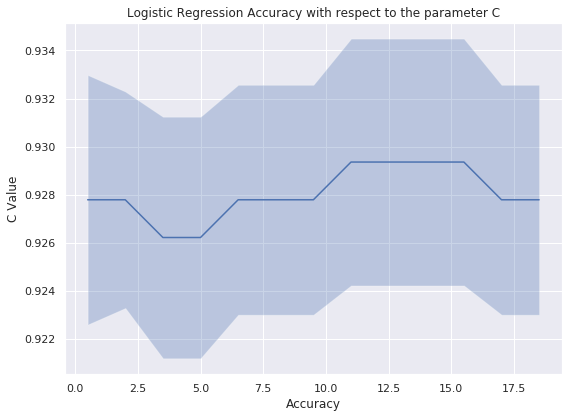

In [0]:
fig = sns.lineplot(x=lr_parameters_grid[0]["C"], y=acc_means)

# fig.errorbar(tuned_parameters[0]["C"], acc_means+.2*acc_stds, acc_means-.2*acc_stds)
fig.fill_between(lr_parameters_grid[0]["C"]\
                 , acc_means+.3*acc_stds\
                 , acc_means-.3*acc_stds, alpha=.3) 
plt.xlabel("Accuracy")
plt.ylabel("C Value")
plt.title("Logistic Regression Accuracy with respect to the parameter C") # You can comment this line out if you don't need title
plt.show(fig)

We can see from the graph and from the "Detailed classification report" above that the best value for the parameter $C$ is around $11$ (on the training set). Nevertheless, the differences between the obtained accuracies are small (ranging between $\pm 0.5\%$).

The accuracy score we obtained for Logistic Regression is  __$\approx 92.5\%$__.

### Random Forests

We will use again a  grid search to find good parameters for our Random Forests model.

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rf_parameters_grid = [{"n_estimators": np.arange(75, 200, 30)\
                    , "max_depth": [5]\
                    , "bootstrap": [True, False]}]

In [0]:
acc_means, acc_stds = grid_search_parameters(RandomForestClassifier()\
                                             , rf_parameters_grid)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'bootstrap': True, 'max_depth': 5, 'n_estimators': 165}

Grid scores on development set:

0.9294 (+/-0.0279) for {'bootstrap': True, 'max_depth': 5, 'n_estimators': 75}
0.9278 (+/-0.0229) for {'bootstrap': True, 'max_depth': 5, 'n_estimators': 105}
0.9246 (+/-0.0368) for {'bootstrap': True, 'max_depth': 5, 'n_estimators': 135}
0.9341 (+/-0.0273) for {'bootstrap': True, 'max_depth': 5, 'n_estimators': 165}
0.9184 (+/-0.0418) for {'bootstrap': True, 'max_depth': 5, 'n_estimators': 195}
0.9325 (+/-0.0288) for {'bootstrap': False, 'max_depth': 5, 'n_estimators': 75}
0.9309 (+/-0.0267) for {'bootstrap': False, 'max_depth': 5, 'n_estimators': 105}
0.9246 (+/-0.0342) for {'bootstrap': False, 'max_depth': 5, 'n_estimators': 135}
0.9309 (+/-0.0248) for {'bootstrap': False, 'max_depth': 5, 'n_estimators': 165}
0.9294 (+/-0.0263) for {'bootstrap': False, 'max_depth': 5, 'n_estimators': 195}

Detailed classific

We can see from the detailed report above that the best found parameters for the Random Forests are 
```max_depth=5```, ```n_estimators=165``` and ```bootstrap=True```. The Random Forests classifier has an accuracy of $\approx 93.4\%$. 


## K Nearest Neighbors classifier 

Same grid search for the KNN as well:

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
knn_parameters_grid = [{"n_neighbors": np.arange(1, 20)}]
acc_means, acc_stds = grid_search_parameters(KNeighborsClassifier()\
                                             , knn_parameters_grid)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.9137 (+/-0.0359) for {'n_neighbors': 1}
0.9184 (+/-0.0194) for {'n_neighbors': 2}
0.8964 (+/-0.0392) for {'n_neighbors': 3}
0.8995 (+/-0.0452) for {'n_neighbors': 4}
0.8932 (+/-0.0349) for {'n_neighbors': 5}
0.8964 (+/-0.0464) for {'n_neighbors': 6}
0.8964 (+/-0.0359) for {'n_neighbors': 7}
0.8885 (+/-0.0398) for {'n_neighbors': 8}
0.8823 (+/-0.0676) for {'n_neighbors': 9}
0.8823 (+/-0.0458) for {'n_neighbors': 10}
0.8838 (+/-0.0357) for {'n_neighbors': 11}
0.8854 (+/-0.0477) for {'n_neighbors': 12}
0.8885 (+/-0.0453) for {'n_neighbors': 13}
0.8917 (+/-0.0384) for {'n_neighbors': 14}
0.8854 (+/-0.0607) for {'n_neighbors': 15}
0.8807 (+/-0.0497) for {'n_neighbors': 16}
0.8776 (+/-0.0502) for {'n_neighbors': 17}
0.8681 (+/-0.0481) for {'n_neighbors': 18}
0.8697 (+/-0.0538) for {'n_neighbors': 19}

Detailed classification report:

The model is train

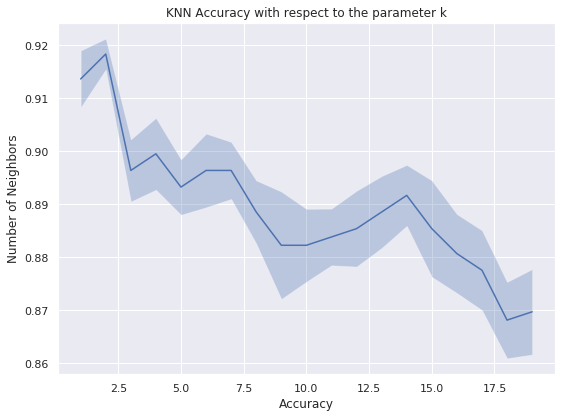

In [0]:
fig = sns.lineplot(x=knn_parameters_grid[0]["n_neighbors"], y=acc_means)

# fig.errorbar(tuned_parameters[0]["C"], acc_means+.2*acc_stds, acc_means-.2*acc_stds)
fig.fill_between(knn_parameters_grid[0]["n_neighbors"]\
                 , acc_means+.3*acc_stds\
                 , acc_means-.3*acc_stds, alpha=.3) 
plt.xlabel("Accuracy")
plt.ylabel("Number of Neighbors")
plt.title("KNN Accuracy with respect to the parameter k") # You can comment this line out if you don't need title
plt.show(fig)

We can see that the KNN has the best hyper-parameter ```k=2```. The accuracy of KNN is $\approx 91.8\%$

### Comparison on the evaluation set

Now we look to the evaluation set took of in the beginning.

We normalize our data, complete the missing heights and normalize our heights afterwards

In [0]:
y_eval = evaluation_data["Breed Name"]
X_eval = evaluation_data.drop(columns=["Longevity(yrs)"])
height_relevant_data = pd.get_dummies(X_eval.copy().drop(columns=["Owner Name"]),\
                                     columns=["Energy level", "Attention Needs", "Coat Lenght", "Sex"])

normed_X_eval = (height_relevant_data.drop(columns=["Breed Name", "Height(cm)"]) - norm_X_train_mean) / norm_X_train_std
predicted_height = rfr_model.predict(normed_X_eval)
normed_X_eval["Height(cm)"] = np.where(X_eval['Height(cm)'].isna(), predicted_height, X_eval['Height(cm)'])
normed_X_eval["Height(cm)"] = (normed_X_eval["Height(cm)"] - mean_train_height) / std_train_height 

We train each classifier with on the training set with the best parameters found by the Grid Search: 

In [0]:
class_results                   = normed_X_eval.copy()
class_results["Breed Name"]     = y_eval
class_results["KNN Prediction"] = KNeighborsClassifier(2)\
                                    .fit(X_train.drop(columns=["Breed Name"]).values, y_train)\
                                    .predict(normed_X_eval)
class_results["RF Prediction"]  = RandomForestClassifier(bootstrap=True, max_depth=5, n_estimators=165)\
                                    .fit(X_train.drop(columns=["Breed Name"]).values, y_train)\
                                    .predict(normed_X_eval)
class_results["LR Prediction"]  = LogisticRegression(C=11).fit(X_train.drop(columns=["Breed Name"]).values, y_train)\
                                    .fit(X_train.drop(columns=["Breed Name"]).values, y_train)\
                                    .predict(normed_X_eval)


/home/stefan/anaconda3/envs/data_mining/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stefan/anaconda3/envs/data_mining/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/stefan/anaconda3/envs/data_mining/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stefan/anaconda3/envs/data_mining/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


We now plot how the models classified the evaluation set in comparison to the true labels.

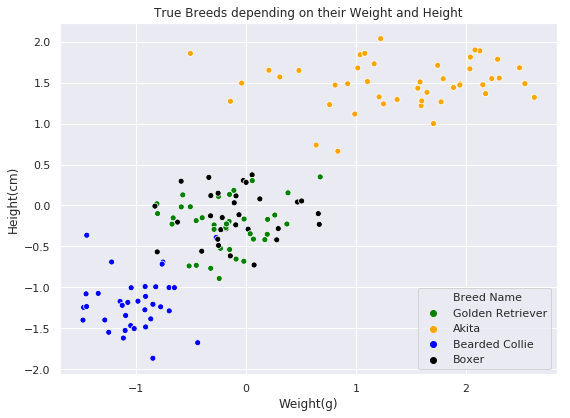

In [0]:
sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="Breed Name", palette=colors_dict\
                , data=class_results\
               ).set_title("True Breeds depending on their Weight and Height")
plt.show()

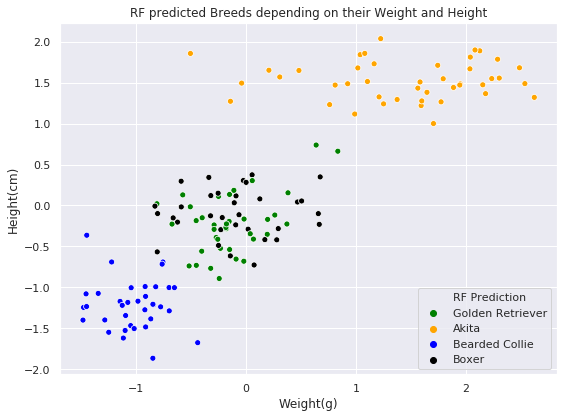

In [0]:
sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="RF Prediction", palette=colors_dict\
                , data=class_results\
               ).set_title("RF predicted Breeds depending on their Weight and Height")
plt.show()

In [0]:
rf_accuracy = RandomForestClassifier(bootstrap=True, max_depth=5, n_estimators=165)\
.fit(X_train.drop(columns=["Breed Name"]).values, y_train).score(normed_X_eval, y_eval)

print("The accuracy on the validation set obtained by the Random Forest Classifier is {0:.2f}%.".format(rf_accuracy*100))

The accuracy on the validation set obtained by the Random Forest Classifier is 92.00%.


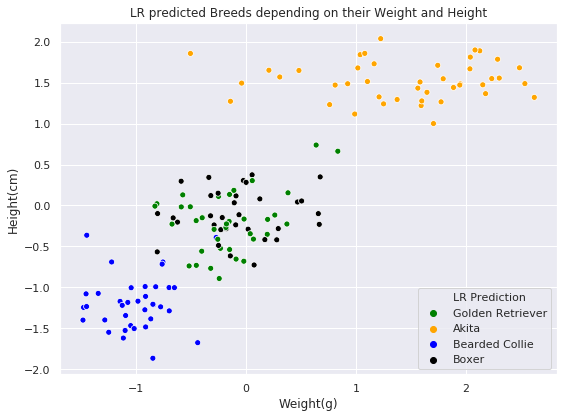

In [0]:
sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="LR Prediction", palette=colors_dict\
                , data=class_results\
               ).set_title("LR predicted Breeds depending on their Weight and Height")
plt.show()

In [0]:
lr_accuracy = LogisticRegression(C=11).fit(X_train.drop(columns=["Breed Name"]).values, y_train).score(normed_X_eval, y_eval)
print("The accuracy on the validation set obtained by the Logistic Regreesion is {0:.2f}%.".format(lr_accuracy*100))

The accuracy on the validation set obtained by the Logistic Regreesion is 92.67%.


/home/stefan/anaconda3/envs/data_mining/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stefan/anaconda3/envs/data_mining/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


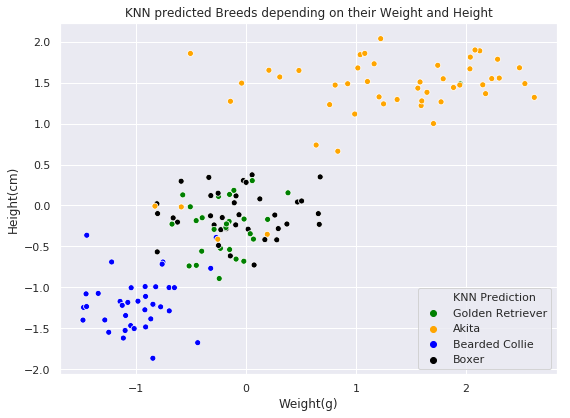

In [0]:
sns.scatterplot(y="Height(cm)", x="Weight(g)", hue="KNN Prediction", palette=colors_dict\
                , data=class_results\
               ).set_title("KNN predicted Breeds depending on their Weight and Height")
plt.show()

In [0]:
knn_accuracy = KNeighborsClassifier(2).fit(X_train.drop(columns=["Breed Name"]).values, y_train).score(normed_X_eval, y_eval)
print("The accuracy on the validation set obtained by the K Nearest Neighbors is {0:.2f}%.".format(knn_accuracy*100))


The accuracy on the validation set obtained by the K Nearest Neighbors is 88.67%.


### Classification task Conclusion

For the provided data set the Logistic Regression and the Random Forest seem to have similar results, both around $92\%$ accuracy on both test and evaluation set. As for the K Nearest Neighbors, we obtain an accuracy of $88.67\%$ on the evaluation set.

However all $3$ models capture the data generation model pretty well, as we can see in the plots above.

# 4. Regression

For the Regression task we will compare Linear Regression and KNN Regression.

In [0]:
complete_data.head()

,Weight(g),Energy level_high,Energy level_low,Energy level_med,Attention Needs_high,Attention Needs_low,Attention Needs_med,Coat Lenght_long,Coat Lenght_med,Coat Lenght_short,Sex_female,Sex_male,Breed Name,Height(cm),Longevity(yrs)
0,-0.674038,1.053710,-0.207665,-0.969881,0.675274,-0.162061,-0.635322,-0.586641,-0.969881,1.692503,1.000986,-1.000986,Boxer,56.285600,8.4255
2,-0.226455,-0.947155,-0.207665,1.029020,-1.477959,-0.162061,1.570900,1.701258,-0.969881,-0.589675,1.000986,-1.000986,Golden Retriever,61.793184,12.0012
3,-0.247464,1.053710,-0.207665,-0.969881,0.675274,-0.162061,-0.635322,-0.586641,-0.969881,1.692503,-0.997045,0.997045,Boxer,59.718100,9.1508
4,0.069339,1.053710,-0.207665,-0.969881,0.675274,-0.162061,-0.635322,-0.586641,-0.969881,1.692503,-0.997045,0.997045,Boxer,58.475500,8.2515
5,-0.820139,1.053710,-0.207665,-0.969881,0.675274,-0.162061,-0.635322,1.701258,-0.969881,-0.589675,-0.997045,0.997045,Bearded Collie,52.508800,12.9680


We first split our data into train and test:

In [0]:
np.random.seed(0)
X, y = complete_data.drop(columns=["Breed Name", "Longevity(yrs)"]), complete_data["Longevity(yrs)"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

We normalize our heights

In [0]:
X_train["Height(cm)"] = (X_train["Height(cm)"] - mean_train_height) / std_train_height
X_test["Height(cm)"]  = (X_test["Height(cm)"] - mean_train_height) / std_train_height

We visualize how would the regression line look on the training set, with respect to the Height and Weight: 

/home/stefan/anaconda3/envs/data_mining/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


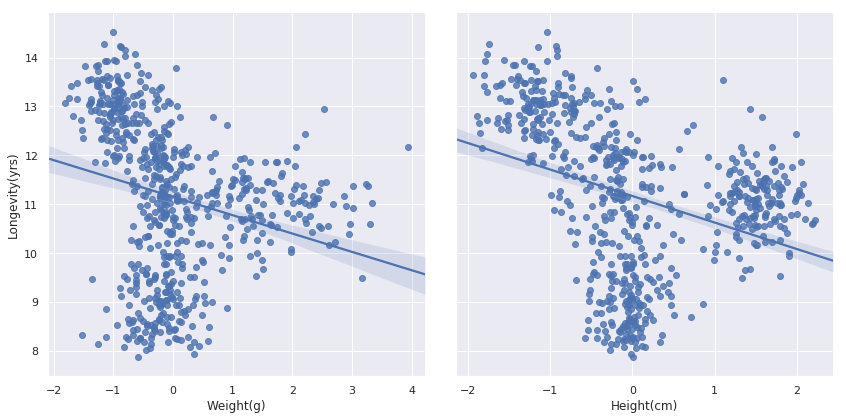

In [0]:
sns.pairplot(data=pd.concat([X_train, y_train], axis=1)\
             , y_vars=["Longevity(yrs)"]\
             , x_vars=["Weight(g)", "Height(cm)"],kind="reg", height=6)

plt.show()

As we can see the data looks highly nonlinear. Therefore we will make some polynomial features starting from the Weight and Height.

In [0]:
from sklearn.preprocessing import PolynomialFeatures

weight_deg = 3
weight_pol = PolynomialFeatures(weight_deg)
weight_features = weight_pol.fit_transform(X_train["Weight(g)"].values.reshape(-1,1))

height_deg = 4
height_pol = PolynomialFeatures(height_deg)
height_features = height_pol.fit_transform(X_train["Height(cm)"].values.reshape(-1,1))

#Store the polynomial features into a DataFrame
height_df = pd.DataFrame(data=height_features\
                         , columns=["height_" + str(i) for i in range(height_deg+1)]\
                        , index = X_train.index)
weight_df = pd.DataFrame(data=weight_features, columns=["weight_" + str(i) for i in range(weight_deg+1)]\
                        , index = X_train.index)

#Gather all features in a big DataFrame
regression_train = pd.concat([X_train.drop(columns=["Weight(g)", "Height(cm)"]),\
                             height_df, weight_df],
                            axis=1)

We create the same polynomial features for the test set:

In [0]:
height_test_features = height_pol.fit_transform(X_test["Height(cm)"].values.reshape(-1,1))
height_test_df  = pd.DataFrame(data=height_test_features\
                         , columns=["height_" + str(i) for i in range(height_deg+1)]\
                        , index = X_test.index)

weight_test_features = weight_pol.fit_transform(X_test["Weight(g)"].values.reshape(-1,1))
weight_test_df  = pd.DataFrame(data=weight_test_features, columns=["weight_" + str(i) for i in range(weight_deg+1)]\
                        , index = X_test.index)

regression_test = pd.concat([X_test.drop(columns=["Weight(g)", "Height(cm)"]),\
                             height_test_df, weight_test_df],
                            axis=1)

We now train the regression models:

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [0]:
lr_reg_model = LinearRegression()
lr_reg_model.fit(regression_train, y_train)

print("Linear Regression R^2 score is:", lr_reg_model.score(regression_test, y_test))

Linear Regression R^2 score is: 0.6733916201611889


In [0]:
knn_reg_model = KNeighborsRegressor()
knn_reg_model.fit(regression_train, y_train)
print("KNN Regression R^2 score is:", knn_reg_model.score(regression_test, y_test))

KNN Regression R^2 score is: 0.7270860396092573


We now plot the results obtained by our regression models:

In [0]:
regression_results = X_test.copy()
regression_results["KNN Reg. Prediction"]  = knn_reg_model.predict(regression_test)
regression_results["Lin. Reg. Prediction"] = lr_reg_model.predict(regression_test)


### KNN regression results

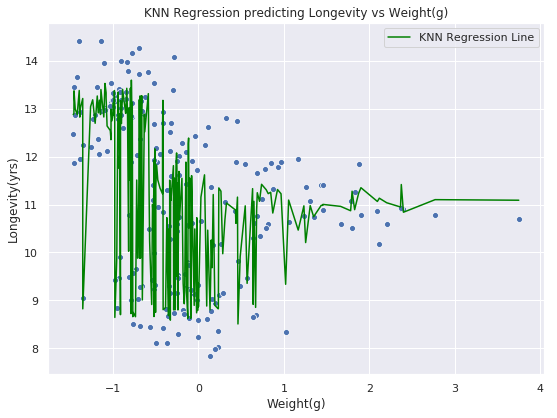

In [0]:

sns.lineplot(x="Weight(g)", y="KNN Reg. Prediction", data=regression_results, label="KNN Regression Line", color="green")
sns.scatterplot(x="Weight(g)", y="Longevity(yrs)", data=pd.concat([regression_results, y_test], axis=1))

plt.title("KNN Regression predicting Longevity vs Weight(g)")
plt.show()

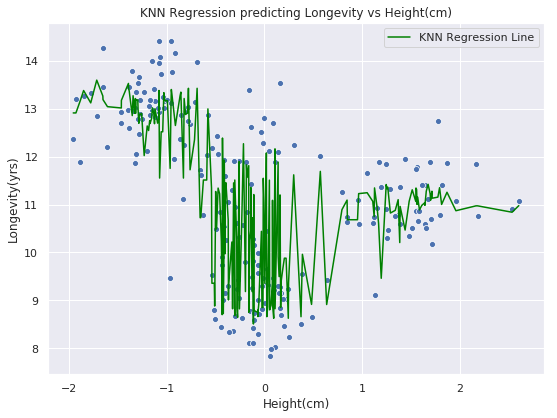

In [0]:
sns.lineplot(x="Height(cm)", y="KNN Reg. Prediction", data=regression_results, label="KNN Regression Line", color="green")
sns.scatterplot(x="Height(cm)", y="Longevity(yrs)", data=pd.concat([regression_results, y_test], axis=1))

plt.title("KNN Regression predicting Longevity vs Height(cm)")
plt.show()

Simple Linear Regression plots

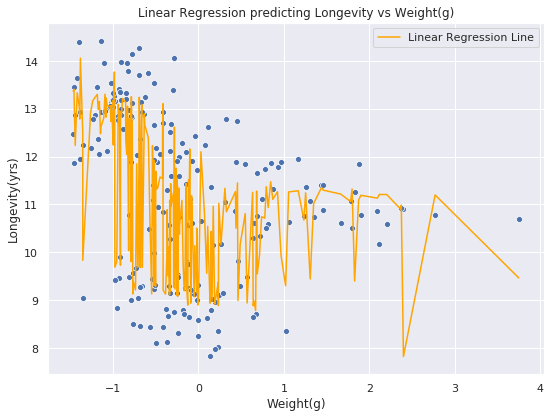

In [0]:
sns.lineplot(x="Weight(g)", y="Lin. Reg. Prediction", data=regression_results, label="Linear Regression Line", color="orange")
sns.scatterplot(x="Weight(g)", y="Longevity(yrs)", data=pd.concat([regression_results, y_test], axis=1))

plt.title("Linear Regression predicting Longevity vs Weight(g)")
plt.show()

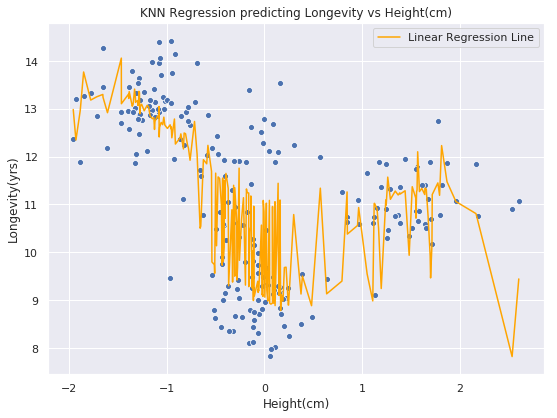

In [0]:
sns.lineplot(x="Height(cm)", y="Lin. Reg. Prediction", data=regression_results, label="Linear Regression Line", color="orange")
sns.scatterplot(x="Height(cm)", y="Longevity(yrs)", data=pd.concat([regression_results, y_test], axis=1))

plt.title("KNN Regression predicting Longevity vs Height(cm)")
plt.show()

We can see that both KNN and Linear Regression catch some of the model complexity, but KNN seems to have a slightly higher score (both are around $0.7$ $R^2$ score).

Finally we will the test the Regression models on the evaluation set:

In [0]:
reg_evaluation_data = evaluation_data.copy()
y_eval = reg_evaluation_data["Longevity(yrs)"]
X_eval = reg_evaluation_data.drop(columns=["Breed Name"])
long_relevant_data = pd.get_dummies(X_eval.copy().drop(columns=["Owner Name"]),\
                                     columns=["Energy level", "Attention Needs", "Coat Lenght", "Sex"])

normed_X_eval = (height_relevant_data.drop(columns=["Breed Name", "Height(cm)"]) - norm_X_train_mean) / norm_X_train_std
predicted_height = rfr_model.predict(normed_X_eval)
normed_X_eval["Height(cm)"] = np.where(X_eval['Height(cm)'].isna(), predicted_height, X_eval['Height(cm)'])
normed_X_eval["Height(cm)"] = (normed_X_eval["Height(cm)"] - mean_train_height) / std_train_height 

In [0]:
normed_X_eval.head()

,Weight(g),Energy level_high,Energy level_low,Energy level_med,Attention Needs_high,Attention Needs_low,Attention Needs_med,Coat Lenght_long,Coat Lenght_med,Coat Lenght_short,Sex_female,Sex_male,Height(cm)
993,-0.087503,-0.947155,-0.207665,1.029020,0.675274,-0.162061,-0.635322,-0.586641,-0.969881,1.692503,1.000986,-1.000986,-0.655190
859,1.018399,-0.947155,4.805956,-0.969881,-1.477959,6.158332,-0.635322,-0.586641,1.029020,-0.589675,1.000986,-1.000986,1.679280
298,-1.472795,1.053710,-0.207665,-0.969881,0.675274,-0.162061,-0.635322,1.701258,-0.969881,-0.589675,1.000986,-1.000986,-1.245068
553,-0.229455,-0.947155,-0.207665,1.029020,0.675274,-0.162061,-0.635322,-0.586641,1.029020,-0.589675,-0.997045,0.997045,-0.523678
672,1.593412,-0.947155,-0.207665,1.029020,-1.477959,-0.162061,1.570900,-0.586641,1.029020,-0.589675,1.000986,-1.000986,1.219668


In [0]:
weight_eval_features = weight_pol.fit_transform(normed_X_eval["Weight(g)"].values.reshape(-1,1))
height_eval_features = height_pol.fit_transform(normed_X_eval["Height(cm)"].values.reshape(-1,1))

In [0]:
#Store the polynomial features into a DataFrame
height_df = pd.DataFrame(data=height_eval_features\
                         , columns=["height_" + str(i) for i in range(height_deg+1)]\
                        , index = normed_X_eval.index)
weight_df = pd.DataFrame(data=weight_eval_features, columns=["weight_" + str(i) for i in range(weight_deg+1)]\
                        , index = normed_X_eval.index)

#Gather all features in a big DataFrame
regression_eval = pd.concat([normed_X_eval.drop(columns=["Weight(g)", "Height(cm)"]),\
                             height_df, weight_df],
                            axis=1)

#Make columns from the predictions
regression_eval_results = normed_X_eval.copy()
regression_eval_results["KNN Reg. Prediction"]  = knn_reg_model.predict(regression_eval)
regression_eval_results["Lin. Reg. Prediction"] = lr_reg_model.predict(regression_eval)


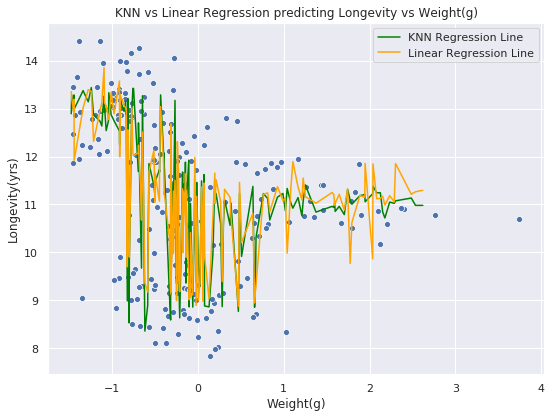

In [0]:
sns.lineplot(x="Weight(g)", y="KNN Reg. Prediction", data=regression_eval_results, label="KNN Regression Line", color="green")
sns.lineplot(x="Weight(g)", y="Lin. Reg. Prediction", data=regression_eval_results, label="Linear Regression Line", color="orange")
sns.scatterplot(x="Weight(g)", y="Longevity(yrs)", data=pd.concat([regression_results, y_test], axis=1))

plt.title("KNN vs Linear Regression predicting Longevity vs Weight(g)")
plt.show()

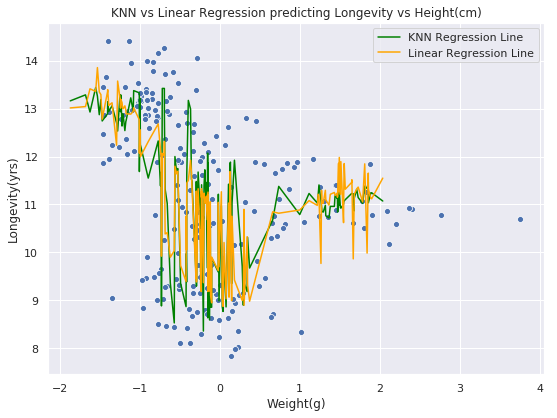

In [0]:
sns.lineplot(x="Height(cm)", y="KNN Reg. Prediction", data=regression_eval_results, label="KNN Regression Line", color="green")
sns.lineplot(x="Height(cm)", y="Lin. Reg. Prediction", data=regression_eval_results, label="Linear Regression Line", color="orange")
sns.scatterplot(x="Weight(g)", y="Longevity(yrs)", data=pd.concat([regression_results, y_test], axis=1))

plt.title("KNN vs Linear Regression predicting Longevity vs Height(cm)")
plt.show()

### Regression Conclusion

For the provided data set the KNN Regression is able to obtain a higher score then the simple Linear Regression. 

In [0]:
print("The R^2 score of Linear Regression on the evaluation set is:", lr_reg_model.score(regression_eval, y_eval))
print("The R^2 score of KNN Regression on the evaluation set is:", knn_reg_model.score(regression_eval, y_eval))


The R^2 score of Linear Regression on the evaluation set is: 0.5363706426542081
The R^2 score of KNN Regression on the evaluation set is: 0.6096349510774164
